### Kobe Bryant

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator

<h4><strong>Загрузим данные и создадим несколько полезных полей</strong></h4>
<p>Показываем вновь созданные поля в качестве проверки на вменяемость.</p>

In [2]:
data = pd.read_csv('kobe.csv')

In [3]:
# Добавляем несколько временных столбцов к данным
data['game_date'] = pd.to_datetime(data['game_date'])
data['dayOfWeek']    = data['game_date'].dt.dayofweek
data['dayOfYear']    = data['game_date'].dt.dayofyear

# Секунды до окончания игры
data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']

# Время начала после попадания
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int) * (data['period'] - 1) * 12 * 60 + (data['period'] > 4).astype(int) * ((data['period'] - 4) * 5 * 60 + 3 * 12 * 60) + data['secondsFromPeriodStart']

# Посмотрим на первые пару рядов и убедимся, что все хорошо
data.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

,period,minutes_remaining,seconds_remaining,secondsFromGameStart
0,1,10,27,93
1,1,10,22,98
2,1,7,45,255
3,1,6,52,308
4,2,6,19,1061
5,3,9,32,1588
6,3,8,52,1628
7,3,8,5,1675
8,3,6,12,1788
9,3,3,36,1944


#### Пропущенные значения

In [4]:
missing_values_columns = []
for col in data.columns:
    pct_missing = data[col].isnull().sum()
    if pct_missing > 0:
        missing_values_columns.append(col)
        print(f' {pct_missing} - {col}')

 5000 - shot_made_flag


In [5]:
#Находим категориальные признаки
cat_feature = list(data.dtypes[data.dtypes == object].index)

datetime_ = list(data.dtypes[data.dtypes == 'datetime64[ns]'].index)

#отфильтруем непрерывные признаки
num_feature = [f for f in data if f not in (cat_feature + datetime_)]

In [6]:
df = data.dropna()

In [7]:
# Создаем дамми-переменные для категорий
dummy = pd.get_dummies(df[cat_feature], columns=cat_feature)

#### Запишем пропущенные значения для разметки в отдельный Dataframe.  
После обучения основной части вернемся и заполним пропуски

In [228]:
# Data_predict = pd.concat([data[num_feature], dummy], axis=1)
# Data_predict = data.loc[data['shot_made_flag'].isnull(), :]

#### Удалим пропуски из нашего датасета

In [9]:
df = pd.concat([df[num_feature], dummy], axis=1)

In [10]:
target = 'shot_made_flag'

#### Построим гауссовскую модель смеси, которая пытается компактно резюмировать места выстрелов Кобе

In [11]:
# Группа попыток бросков Кобе, используя "Гауссову модель смеси" на их месте
numGaussians = 13
gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
gaussianMixtureModel.fit(data.loc[:,['loc_x','loc_y']])

# добавем группу "Гауссову модель смеси" в качестве поля в набор данных
data['shotLocationCluster'] = gaussianMixtureModel.predict(data.loc[:,['loc_x','loc_y']])

<h4>Определите некоторые вспомогательные функции</h4>
<p>функция draw_court() бесстыдно украдена из превосходного скрипта Михаэля Крюгера</p>

In [12]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # Если объект axes не предусмотрен для построения графика, просто получите текущий
    if ax is None:
        ax = plt.gca()

    # Создайте различных частей баскетбольной площадки НБА

    # Создание баскетбольного кольцо
    
    # Диаметр обруча составляет 18 дюймов, поэтому он имеет радиус 9 дюймов, 
    # что является значением 7.5 в нашей системе координат
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Сощдание баскетбольного щита
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # Отрисовка
    
    # Создание внещней коробки, шириной = 16ft, высотой = 19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    
    # Создание внутренней коробки, шириной = 12ft, высотой = 19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Создание верхней дуги штрафного броска
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    
    # Создание нижней дуги штрафного броска
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    
    # Зона ограниченного доступа, это дуга радиусом 4 фута от центра обруча.
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Трехочковая линия
    # Создайте трехочковой линии, она имет длину 14 футов.
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    
    # Трехочковая дуга - центром дуги будет обруч, сама дуга находится на расстоянии 23 футов 9 дюймов от обруча
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Центральный корт
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # Перечень элементов площадки для нанесения на оси
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Отрисовка центарльной, базовой и боковой линии 
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Добавьление элементы площадки на оси
    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        
        # Получить собственные векторы и собственные значения ковариационной матрицы
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # Переход к единицам стандартного отклонения вместо дисперсии
        
        # Вычисление уголов эллипса и длин двух осей и их отрисовка
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # Конвертиртация в градусы
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=13, color='blue')

<h4>Отрисовка двумерных гауссиан попыток бросков</h4>
<p>Каждый эллипс - это контур, который представляет собой 2,5 стандартных отклонения от центра гауссианы. Каждое число синего цвета представляет процент бросков, сделанных с помощью этого гауссиана, от всех бросков.</p>

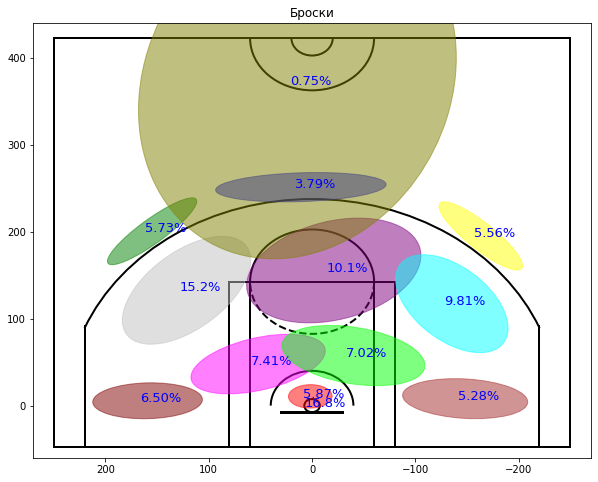

In [13]:
# Отображение эллипсов гауссовой смеси попыток бросков
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 10

ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4]+'%' for x in range(numGaussians)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True)
plt.ylim(-60,440)
plt.xlim(270,-270)
plt.title('Броски');

<blockquote>
<p>Мы видим, что Кобе делает больше попыток с <strong>левой стороны</strong> поля(или с <strong>правой стороны</strong>, с его точки зрения). Это вероятно потому, что он <strong>правша</strong>.</p>
<p>Также мы видим, что огромное количество попыток (16,8%) происходит непосредственно из-под корзины, а 5,21% дополнительных попыток - из очень близких к корзине.</p>
</blockquote>

<h4>Построение графика точности бросков каждой гауссовской группы</h4>
<p>Каждое синее число здесь будет представлять точность броска, сделанных из этого кластера, чтобы мы могли почувствовать, какие броски простые, а какие сложные для Кобе.</p>

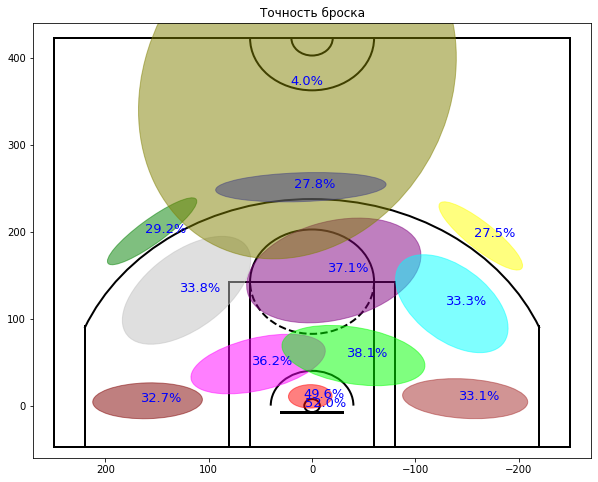

In [14]:
# Для каждой группы рассчитаем ее индивидуальную точность и построим
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 10

variableCategories = data['shotLocationCluster'].value_counts().index.tolist()

clusterAccuracy = {}
for category in variableCategories:
    shotsAttempted = np.array(data['shotLocationCluster'] == category).sum()
    shotsMade = np.array(data.loc[data['shotLocationCluster'] == category,'shot_made_flag'] == 1).sum()
    clusterAccuracy[category] = float(shotsMade)/shotsAttempted

ellipseTextMessages = [str(100*clusterAccuracy[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('Точность броска');

<blockquote>
<p id="We-can-clearly-see-the-dependence-between-distance-and-accuracy">Мы можем ясно видеть зависимость между расстоянием и точностью.<br />Еще один интересный факт заключается в том, что Кобе не только делает больше попыток с правой стороны (с его точки зрения), но и реализовывает эти попытки лучше.</p>
</blockquote>

#### Отбор признаков

In [16]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

DTR = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, max_features=0.5)

# Выполним стандартизацию признаков
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# Обучем наши признаки
sc.fit(df.drop(target, 1))

# Тренировочные значения 
Х_std = sc.transform(df.drop(target, 1))

# Обучим для отбора признаков
DTR.fit(Х_std, df[target])

DecisionTreeRegressor(max_depth=5, max_features=0.5, min_samples_leaf=10)

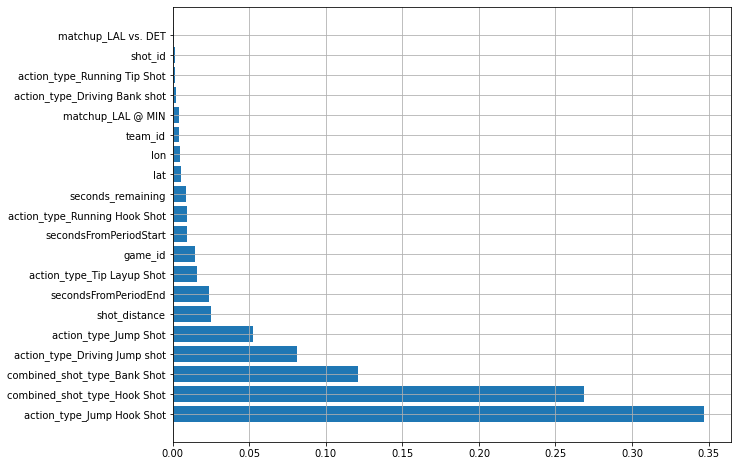

In [17]:
imp = pd.Series(DTR.feature_importances_)
imp = imp.sort_values(ascending=False)

# Выберем порог значений для отбора признаков
Threshold = 0.0002

amount = sum(np.where(imp.values > Threshold, 1, 0))
imp = imp[:amount]
    
plt.barh(np.arange(len(imp)), imp.values)
plt.yticks(np.arange(len(imp.index.values)), df.iloc[:, imp.index.values].columns)
plt.grid( b = None , which = 'both' , axis = 'both');

In [18]:
feature_col = df.iloc[:, imp[:amount].index.values].columns
print(f'Для дальнейшего обучения возьмем {amount} отобранных признаков')

Для дальнейшего обучения возьмем 20 отобранных признаков


In [219]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate, cross_val_predict


from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df[feature_col], df[target].values,
                                                    test_size = 0.3, random_state = 0)

# Выполним стандартизацию признаков
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

Х_train_std = sc.fit_transform(X_train)
Х_test_std = sc.fit_transform(X_test)

# Linear Model trained without L1 L2 regularizer
lr = linear_model.LogisticRegression(C=0.1, solver='liblinear', multi_class='ovr')

# Linear Model trained with L1 prior as regularizer (aka the Lasso)
lr_l1 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='liblinear', multi_class='ovr')

# Linear Model trained with L2 prior as regularizer (aka the Ridge)
lr_l2 = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='lbfgs', random_state = 0)

# Крос валидация для оценки модели
print('Scoring as ROC AUC score\n')

for i in (lr, lr_l1, lr_l2):
    
    scores = cross_validate(i, Х_train_std, Y_train,
                                groups=None, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0,
                               fit_params=None, pre_dispatch='2*n_jobs', return_train_score=True, 
                               return_estimator=False)
    
    # Linear Model trained 
    print(f'Model {i}\n')  
    
    print('Train_score: {} +- {} '.format(scores['train_score'].mean().round(5), 
                                          round(scores['train_score'].std() * 2, 5) ))

    print('Test_score:  {} +- {} \n'.format(scores['test_score'].mean().round(5), 
                                          round(scores['test_score'].std() * 2, 5) ))

Scoring as ROC AUC score

Model LogisticRegression(C=0.1, multi_class='ovr', solver='liblinear')

Train_score: 0.6693 +- 0.00272 
Test_score:  0.66622 +- 0.00931 

Model LogisticRegression(C=0.1, multi_class='ovr', penalty='l1', solver='liblinear')

Train_score: 0.66933 +- 0.00276 
Test_score:  0.66632 +- 0.00866 

Model LogisticRegression(C=0.01, random_state=0)

Train_score: 0.66886 +- 0.00272 
Test_score:  0.6658 +- 0.00875 

